# 01_Data_Visualization_Teste

## TL;DR
Fazer uma descrição de 3 linhas do objetivo do notebook e conclusões presentes na análise.

## Objetivo

Descrever com clareza qual o objetivo desse notebook.

## Dados

Descrever a base de dados utilizada.

## Modelos (opcional)

Em caso de treinamento ou comparação de modelos, descrever os modelos considerados

## Conclusões
Listar **todas** as conclusões obtidas no notebook:
1. conclusão 1
2. conclusão 2
3. etc.


## Observações importantes:
1. Sempre organize o conteúdo utilizando células markdown e seções. Também utilize células de texto para escrever sua análise das figuras que forem geradas.
2. Lembre-se que essa primeira célula deve ter informação suficiente para entender o que foi feito e quais conclusões você chegou, sem ter que ler o notebook inteiro. Isso agiliza muito a busca por informações ao longo do projeto. Além disso, seu eu do futuro (ou novas pessoas que entrem no projeto) vai agradecer se o seu notebook estiver bem escrito e completo.

# Importando as Bibliotecas

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Importando Dataset

# Importando Bibliotecas para Visualização de Dados

In [ ]:
def carregar_dados(base_path='../../data/data_cluster'):
    """
    Carrega todas as séries temporais dos voluntários
    
    Args:
        base_path: caminho base onde estão as pastas dos voluntários
        
    Returns:
        Dicionário com:
            - series: lista de arrays numpy com as séries temporais
            - voluntarios: lista identificando o voluntário de cada série
            - arquivos: lista com nomes dos arquivos de origem
    """
    dados = {
        'series': [],
        'voluntarios': [],
        'arquivos': []
    }
    
    # Lista todos os diretórios de voluntários
    voluntarios = [d for d in os.listdir(base_path) 
                  if os.path.isdir(os.path.join(base_path, d)) and d.startswith('voluntario')]
    
    for vol in voluntarios:
        vol_path = os.path.join(base_path, vol)
        arquivos = [f for f in os.listdir(vol_path) if f.endswith('.csv')]
        
        for arq in arquivos:
            try:
                # Carrega o CSV assumindo que a série temporal está em uma coluna
                df = pd.read_csv(os.path.join(vol_path, arq), header=None)
                serie = df.values.flatten()
                
                dados['series'].append(serie)
                dados['voluntarios'].append(vol)
                dados['arquivos'].append(arq)
            except Exception as e:
                print(f"Erro ao carregar {vol}/{arq}: {str(e)}")
    
    return dados

# Carrega todos os dados
dados = carregar_dados()

In [6]:

# Verifica quantas séries foram carregadas
print(f"Total de séries carregadas: {len(dados['series'])}")
print(f"Voluntários encontrados: {set(dados['voluntarios'])}")


Total de séries carregadas: 50
Voluntários encontrados: {'voluntario4', 'voluntario5', 'voluntario2', 'voluntario3', 'voluntario1'}


# Antes de aplicar os algoritmos de clusterização, precisamos:
1. Normalizar as séries temporais
2. Padronizar o comprimento (se necessário)

In [10]:
def preparar_dados(dados):
    """
    Prepara os dados para clusterização, lidando com comprimentos diferentes
    
    Args:
        dados: dicionário com as séries temporais
        
    Returns:
        series_normalizadas: séries temporais normalizadas e padronizadas
        comprimentos: lista com comprimento original de cada série
    """
    # Converte para formato aceito pelo tslearn
    series_dataset = to_time_series_dataset(dados['series'])
    
    # Normalização das séries temporais
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    series_normalizadas = scaler.fit_transform(series_dataset)
    
    return series_normalizadas

# Prepara os dados
try:
    series_normalizadas = preparar_dados(dados)
    print(f"Formato dos dados normalizados: {series_normalizadas.shape}")
    
    # Verifica comprimentos das séries
    comprimentos = [len(serie[~np.isnan(serie)]) for serie in series_normalizadas]
    print(f"Comprimento mínimo: {min(comprimentos)}")
    print(f"Comprimento máximo: {max(comprimentos)}")
    
except Exception as e:
    print(f"Erro durante o pré-processamento: {str(e)}")

c:\Users\Yama\Documents\Iniciação Científica\Github\movimento\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Yama\Documents\Iniciação Científica\Github\movimento\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Formato dos dados normalizados: (50, 26875, 1)
Comprimento mínimo: 4675
Comprimento máximo: 26875


## 3. Clusterização com K-means Tradicional

c:\Users\Yama\Documents\Iniciação Científica\Github\movimento\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Yama\Documents\Iniciação Científica\Github\movimento\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


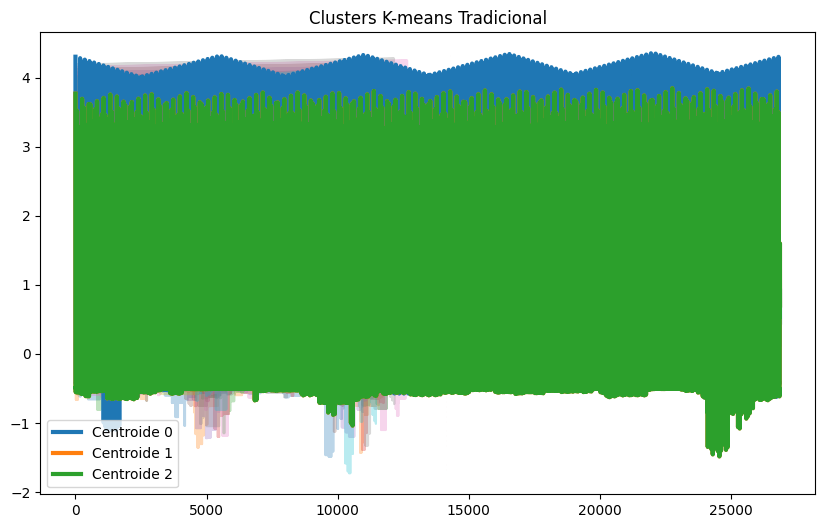

In [11]:
n_clusters = 3

# K-means tradicional
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10, random_state=42)
clusters_km = km.fit_predict(series_normalizadas)

# Adiciona os rótulos aos dados originais
dados['cluster_km'] = clusters_km

# Visualização dos clusters
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_series = [series_normalizadas[i] for i in range(len(series_normalizadas)) 
                     if clusters_km[i] == cluster]
    for serie in cluster_series[:10]:  # Plotando apenas algumas por cluster para melhor visualização
        plt.plot(serie.ravel(), alpha=0.3)
    plt.plot(km.cluster_centers_[cluster].ravel(), linewidth=3, label=f'Centroide {cluster}')

plt.title('Clusters K-means Tradicional')
plt.legend()
plt.show()

## 4. Clusterização com K-means e DTW

In [ ]:
# K-means com DTW
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=42)
clusters_dtw = km_dtw.fit_predict(series_normalizadas)

dados['cluster_dtw'] = clusters_dtw

# Visualização
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_series = [series_normalizadas[i] for i in range(len(series_normalizadas)) 
                     if clusters_dtw[i] == cluster]
    for serie in cluster_series[:10]:
        plt.plot(serie.ravel(), alpha=0.3)
    plt.plot(km_dtw.cluster_centers_[cluster].ravel(), linewidth=3, label=f'Centroide {cluster}')

plt.title('Clusters K-means com DTW')
plt.legend()
plt.show()


c:\Users\Yama\Documents\Iniciação Científica\Github\movimento\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Yama\Documents\Iniciação Científica\Github\movimento\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MemoryError: Allocation failed (probably too large).

: 

# Conclusões

Aqui você deve listar todas as conclusões obtidas ao longo do notebook.
Pode copiar todo o conteúdo dessa seção lá na parte de conclusões do cabeçalho.